# Tutorial 4: Sky Localisation & Fisher-Matrix Analysis with GWFish

This notebook extends **Tutorial 3** (SNR-only detection efficiency) by running the
full **Fisher-matrix** analysis via `compute_network_errors`.  In addition to the
network SNR we obtain:

- **Parameter estimation errors** (masses, distance, inclination, …)
- **90 % credible sky-localisation area** $\Delta\Omega$

We loop over several detector-network configurations and compare detection rates
and sky-localisation distributions.

---

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup

import os
os.environ["OMP_NUM_THREADS"] = "1"   # avoid thread over-subscription
os.environ["MKL_NUM_THREADS"] = "1"

import multiprocessing as mp
cpus = mp.cpu_count()

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import GWFish.modules    as gw
from   GWFish.modules.fishermatrix import compute_network_errors, sky_localization_percentile_factor
from   joblib            import Parallel, delayed
from   astropy.cosmology import Planck18
from   pathlib           import Path

#plt.style.use('../configurations/style.mplstyle')

datafiles  = Path("../datafiles")
output_dir = Path("Output_files/tutorial4_gwfish_skyloc")
output_dir.mkdir(parents=True, exist_ok=True)

## 1. Load the GRB Catalogue

Same catalogue produced in Tutorial 2 (structured-jet model).

In [2]:
cat_path = Path("Output_files/tutorial2_structured/simulated_catalogue.csv")
grb_cat  = pd.read_csv(cat_path)

print(f"Loaded catalogue with {len(grb_cat)} events")
print(f"Columns: {list(grb_cat.columns)}")
grb_cat.head()

Loaded catalogue with 782 events
Columns: ['z', 'theta_v', 'Ep_obs', 'Fp', 'T90']


,z,theta_v,Ep_obs,Fp,T90
0,2.091161,4.034316,539.577283,1.342413,1.339580
1,2.567734,2.755381,623.810608,1.255080,0.634885
2,0.447737,4.679574,613.461947,4.963945,0.531015
3,2.095981,1.383154,245.601566,4.833812,0.363726
4,0.424608,4.495323,300.241420,4.443847,0.554568


## 2. Generate BNS Parameters

Same procedure as Tutorial 3: Gaussian masses, randomised extrinsic parameters.
Here we use **source-frame** masses (`mass_1_source` / `mass_2_source`); GWFish
internally converts to detector-frame.

In [3]:
np.random.seed(42)   # reproducibility

n_ev     = len(grb_cat)
redshift = grb_cat["z"].values
theta_jn = np.deg2rad(grb_cat["theta_v"].values)

# BNS masses — Gaussian (Galactic DNS population)
m1, m2 = np.random.normal(1.33, 0.09, (n_ev, 2)).T
mass_1 = np.maximum(m1, m2)
mass_2 = np.minimum(m1, m2)

params_dict = {
    "mass_1_source"       : mass_1,
    "mass_2_source"       : mass_2,
    "redshift"            : redshift,
    "luminosity_distance" : Planck18.luminosity_distance(redshift).value,
    "theta_jn"            : theta_jn,
    "ra"                  : np.random.uniform(0.0, 2 * np.pi, n_ev),
    "dec"                 : np.arcsin(np.random.uniform(-1.0, 1.0, n_ev)),
    "psi"                 : np.random.uniform(0.0, np.pi, n_ev),
    "phase"               : np.random.uniform(0.0, 2 * np.pi, n_ev),
    "geocent_time"        : np.random.uniform(1577491218, 1609027217, n_ev),
    "a_1"                 : np.zeros(n_ev),
    "a_2"                 : np.zeros(n_ev),
}

df_params = pd.DataFrame(params_dict)
df_params.to_csv(output_dir / "bns_params.csv", index=False)

print(f"Generated {n_ev} BNS parameter sets")
print(f"  <m1> = {mass_1.mean():.3f} Msun,  <m2> = {mass_2.mean():.3f} Msun")
print(f"  z ∈ [{redshift.min():.3f}, {redshift.max():.3f}]")
df_params.head()

Generated 782 BNS parameter sets
  <m1> = 1.385 Msun,  <m2> = 1.283 Msun
  z ∈ [0.056, 5.052]


,mass_1_source,mass_2_source,redshift,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2
0,1.374704,1.317556,2.091161,16813.967216,0.070412,2.182422,1.295540,1.517957,4.798420,1.590308e+09,0.0,0.0
1,1.467073,1.388292,2.567734,21570.794581,0.048090,5.653820,-0.668468,2.633379,3.288628,1.605238e+09,0.0,0.0
2,1.308928,1.308926,0.447737,2559.632940,0.081674,0.137120,0.625115,1.135383,1.424854,1.597948e+09,0.0,0.0
3,1.472129,1.399069,2.095981,16861.187716,0.024141,4.170714,0.954107,2.701125,4.187881,1.605850e+09,0.0,0.0
4,1.378830,1.287747,0.424608,2403.707853,0.078458,6.053186,1.091681,1.278015,0.503319,1.597154e+09,0.0,0.0


## 3. Resolve Detector Configuration

We use the same portable YAML approach from Tutorial 3: bare PSD filenames in
`configs/coba.yaml` are resolved to absolute paths under `psds/` at runtime.

In [4]:
import re, tempfile

yaml_template = Path("configs/coba.yaml")
psd_dir       = Path("psds").resolve()

def resolve_psd_paths(yaml_path, psd_dir):
    """Resolve bare psd_data filenames in a GWFish YAML to absolute paths."""
    text = yaml_path.read_text()
    def _resolve(m):
        fname = m.group(1).strip()
        if fname.startswith("/"):
            return m.group(0)
        resolved = (psd_dir / fname).resolve()
        if not resolved.exists():
            raise FileNotFoundError(
                f"PSD file not found: {resolved}  (referenced in {yaml_path})"
            )
        return f"psd_data:{m.group(0).split('psd_data:')[1].replace(fname, str(resolved))}"
    resolved_text = re.sub(r"psd_data:\s*(.+)", _resolve, text)
    tmp = tempfile.NamedTemporaryFile(
        mode="w", suffix=".yaml", prefix="gwfish_conf_", delete=False
    )
    tmp.write(resolved_text)
    tmp.flush()
    return Path(tmp.name)

conf_file = resolve_psd_paths(yaml_template, psd_dir)
print(f"Resolved config written to: {conf_file}")

Resolved config written to: /tmp/gwfish_conf_knne_sm2.yaml


## 4. Define Detector Combinations

We test several network configurations — from current-generation (2G) detectors
to full 3G networks with Cosmic Explorer.

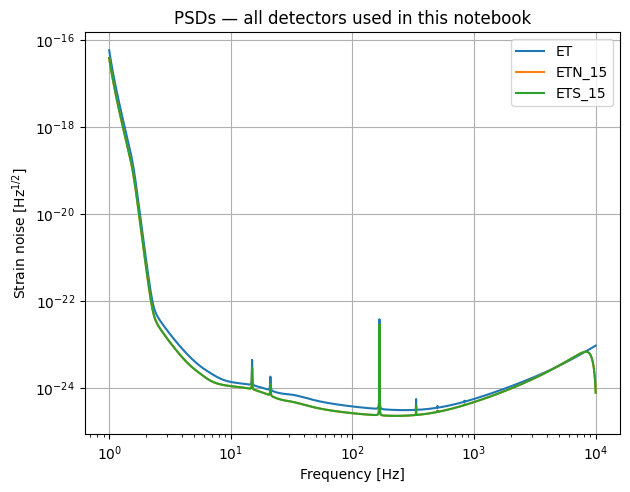

Combinations to analyse: ['3G_2L', '3G_delta']


In [5]:
combinations = {
    "3G_2L"              : ["ETS_15", "ETN_15"],
    "3G_delta"           : ["ET"]
}

waveform_model = "IMRPhenomD_NRTidalv2"
SNR_THRESHOLD  = 8.0

# Quick PSD sanity check — plot all unique detectors
all_det_names = sorted({d for dets in combinations.values() for d in dets})
all_network   = gw.detection.Network(detector_ids=all_det_names, config=conf_file)
for det in all_network.detectors:
    det.components[0].plot_psd()
plt.legend(all_det_names)
plt.title("PSDs — all detectors used in this notebook")
plt.savefig(output_dir / "all_PSDs.pdf")
plt.show()

print(f"Combinations to analyse: {list(combinations.keys())}")

## 5. Run Fisher-Matrix Analysis (All Combinations)

For each detector network we run `compute_network_errors` in parallel using
`functools.partial` + `pool.map`. This returns:

- **SNR** per detector + network
- **Parameter errors** from the Fisher matrix
- **Sky-localisation area** (converted to deg² at 90 % credibility)

In [6]:
results_all  = {}
my_pop_split = np.array_split(df_params, cpus)

for combo_name, det_names in combinations.items():
    print(f"\n{'='*60}")
    print(f"  {combo_name}  →  {det_names}")
    print(f"{'='*60}")

    network = gw.detection.Network(
        detector_ids  = det_names,
        config        = conf_file,
        detection_SNR = (0, SNR_THRESHOLD),
    )

    # ---- joblib parallelisation (much faster than mp.Pool for GWFish) ----
    def run_fisher(chunk_df):
        return compute_network_errors(
            network          = network,
            parameter_values = chunk_df,
            waveform_model   = waveform_model,
        )

    chunks = Parallel(n_jobs=cpus, verbose=10)(
        delayed(run_fisher)(chunk) for chunk in my_pop_split
    )

    # Unpack: each chunk returns (detected, snr, errors, sky_loc)
    _, snr_chunks, errors_chunks, skyloc_chunks = zip(*chunks)

    # compute_network_errors returns 1D SNR (network SNR per event)
    snr_array    = np.concatenate(snr_chunks)
    errors_array = np.concatenate(errors_chunks)
    skyloc_raw   = (np.concatenate(skyloc_chunks)
                    if skyloc_chunks[0] is not None else None)

    # Convert sky localisation to 90 % credible area in deg²
    skyloc_deg2 = (skyloc_raw * sky_localization_percentile_factor()
                   if skyloc_raw is not None else None)

    network_snr  = snr_array
    detected     = network_snr >= SNR_THRESHOLD
    n_det        = int(detected.sum())

    print(f"  Detected {n_det} / {len(network_snr)}  "
          f"({n_det / len(network_snr) * 100:.1f} %)")

    results_all[combo_name] = {
        "det_names"  : det_names,
        "snr"        : snr_array,
        "errors"     : errors_array,
        "skyloc_deg2": skyloc_deg2,
        "detected"   : detected,
    }


  3G_2L  →  ['ETS_15', 'ETN_15']


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
100%|██████████| 98/98 [01:21<00:00,  1.20it/s][Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.4min remaining:  4.3min

100%|██████████| 98/98 [01:22<00:00,  1.19it/s]
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.4min
100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.5min remaining:  1.5min
100%|██████████| 97/97 [01:23<00:00,  1.16it/s]
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.5min remaining:   52.8s
100%|██████████| 97/97 [01:23<00:00,  1.16it/s]
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.5min remaining:   29.3s
100%|██████████| 98/98 [01:24<00:00,  1.16it/s]
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
  0%|          | 0/97 [00:00<?, ?it/s]

  Detected 557 / 782  (71.2 %)

  3G_delta  →  ['ET']


100%|██████████| 98/98 [00:50<00:00,  1.93it/s]
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   50.7s remaining:  2.5min
100%|██████████| 98/98 [00:50<00:00,  1.93it/s]
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   50.9s remaining:  1.4min
100%|██████████| 98/98 [00:51<00:00,  1.91it/s]
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   51.3s remaining:   51.3s
100%|██████████| 97/97 [00:52<00:00,  1.86it/s]
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   52.1s remaining:   31.2s
100%|██████████| 98/98 [00:52<00:00,  1.88it/s]
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   52.2s remaining:   17.4s


  Detected 397 / 782  (50.8 %)


100%|██████████| 98/98 [00:52<00:00,  1.87it/s]
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   52.4s finished


## 6. Detection Rate Summary

In [7]:
print(f"{'Combination':<25s}  {'Detected':>8s}  {'Total':>6s}  {'Rate':>7s}  {'±σ':>7s}")
print("-" * 60)

for combo_name, res in results_all.items():
    n_tot = len(res["detected"])
    n_det = int(res["detected"].sum())
    rate  = n_det / n_tot
    err   = np.sqrt(n_det) / n_tot
    print(f"{combo_name:<25s}  {n_det:>8d}  {n_tot:>6d}  {rate:>7.3f}  {err:>7.3f}")

Combination                Detected   Total     Rate       ±σ
------------------------------------------------------------
3G_2L                           557     782    0.712    0.030
3G_delta                        397     782    0.508    0.025


## 7. Redshift Distribution — Detected vs All

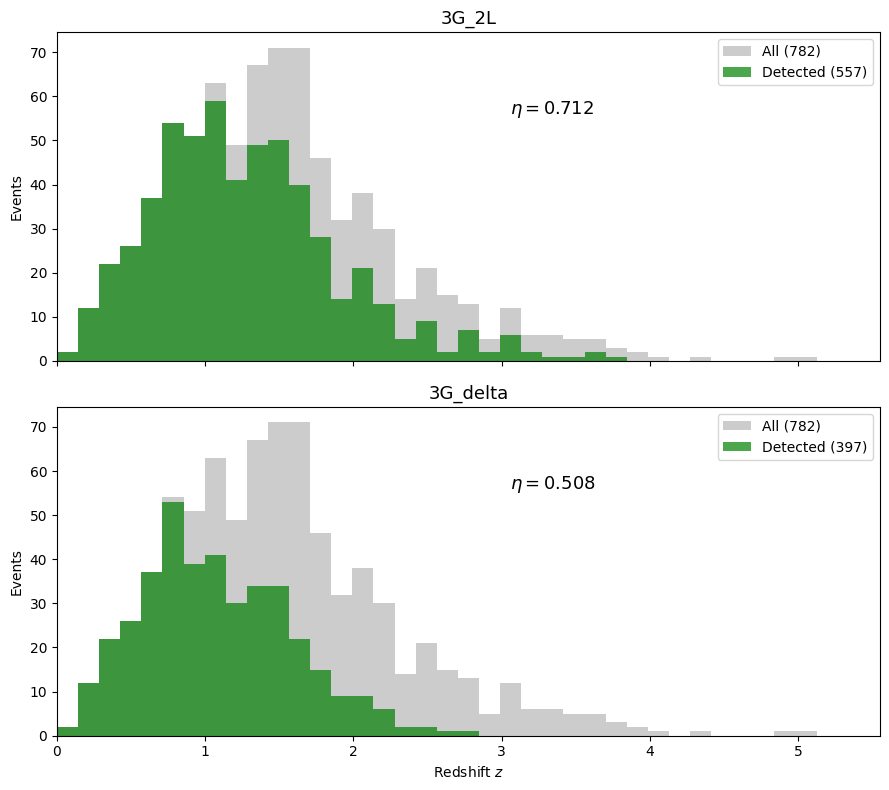

In [8]:
n_combos = len(combinations)
fig, axes = plt.subplots(n_combos, 1, figsize=(9, 4 * n_combos), sharex=True)
if n_combos == 1:
    axes = [axes]

bins = np.linspace(0, redshift.max() + 0.5, 40)

for ax, (combo_name, res) in zip(axes, results_all.items()):
    det_mask = res["detected"]
    n_tot    = len(det_mask)
    n_det    = int(det_mask.sum())

    ax.hist(redshift, bins=bins, color="gray", alpha=0.4,
            label=f"All ({n_tot})")
    ax.hist(redshift[det_mask], bins=bins, color="green", alpha=0.7,
            label=f"Detected ({n_det})")

    rate = n_det / n_tot
    ax.text(0.55, 0.75,
            f"$\\eta = {rate:.3f}$",
            transform=ax.transAxes, fontsize=13)

    ax.set_ylabel("Events")
    ax.set_title(combo_name, fontsize=13)
    ax.legend(fontsize=10)
    ax.set_xlim(0, redshift.max() + 0.5)

axes[-1].set_xlabel("Redshift $z$")
fig.tight_layout()
fig.savefig(output_dir / "redshift_detected_all_combos.pdf", dpi=200, bbox_inches="tight")
plt.show()

## 8. Sky-Localisation Distribution

We compare the 90 % credible sky-localisation area for detected events across
different networks. Vertical lines mark common thresholds (10, 100, 1000 deg²).

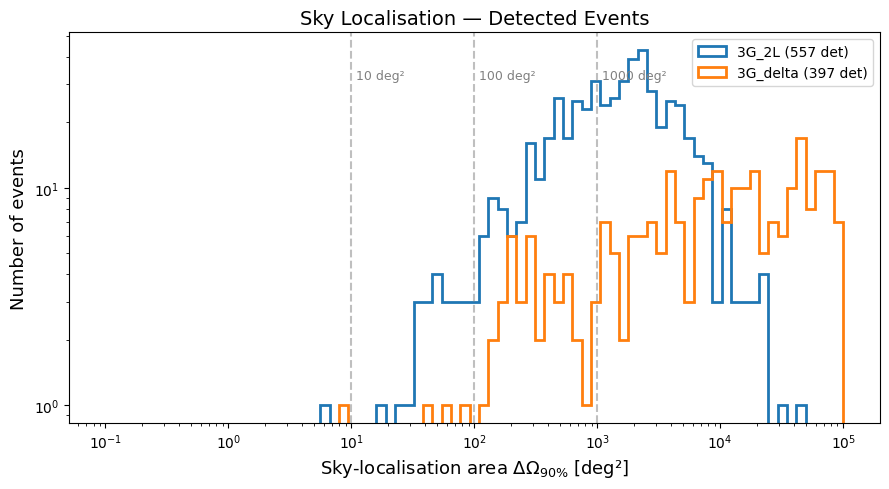

In [9]:
fig, ax = plt.subplots(figsize=(9, 5))

skyloc_bins = np.logspace(-1, 5, 80)

for combo_name, res in results_all.items():
    if res["skyloc_deg2"] is None:
        continue
    det_mask  = res["detected"]
    skyloc_ok = res["skyloc_deg2"][det_mask]
    # filter out NaN / inf
    skyloc_ok = skyloc_ok[np.isfinite(skyloc_ok) & (skyloc_ok > 0)]
    ax.hist(skyloc_ok, bins=skyloc_bins, histtype="step", linewidth=2,
            label=f"{combo_name} ({len(skyloc_ok)} det)")

for threshold in [10, 100, 1000]:
    ax.axvline(threshold, ls="--", color="gray", alpha=0.5)
    ax.text(threshold * 1.1, ax.get_ylim()[1] * 0.7,
            f"{threshold} deg²", fontsize=9, color="gray")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sky-localisation area $\\Delta\\Omega_{90\\%}$ [deg²]", fontsize=13)
ax.set_ylabel("Number of events", fontsize=13)
ax.set_title("Sky Localisation — Detected Events", fontsize=14)
ax.legend(fontsize=10)
fig.tight_layout()
fig.savefig(output_dir / "skyloc_distribution.pdf", dpi=200, bbox_inches="tight")
plt.show()

## 9. Redshift vs Sky Localisation — Threshold Cuts

For each network we show how many events survive progressively tighter
sky-localisation cuts.

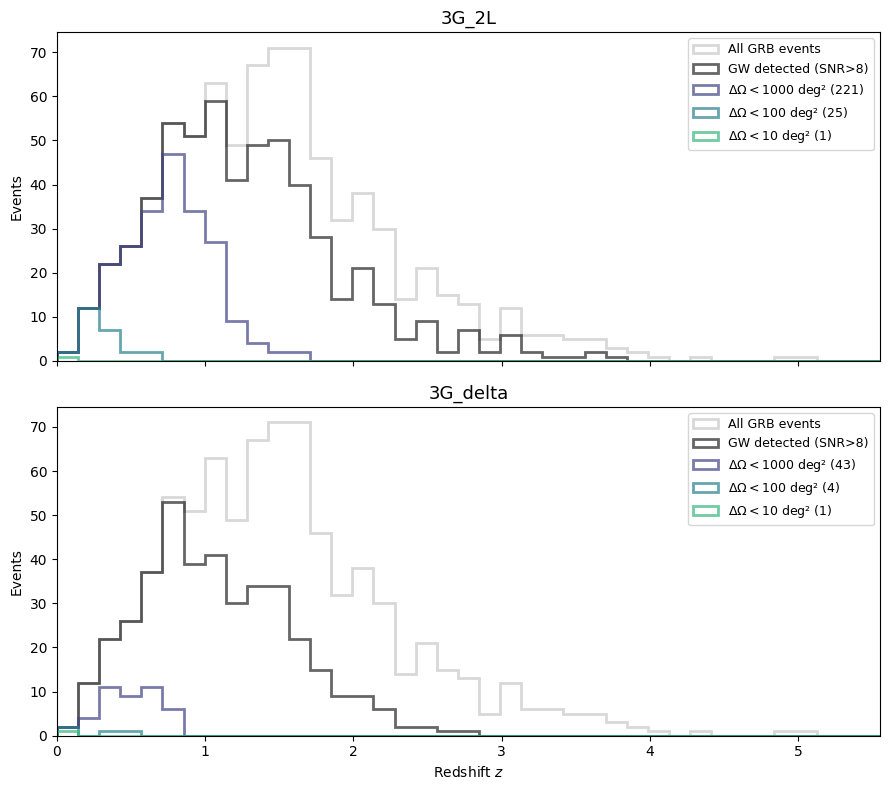

In [10]:
skyloc_thresholds = [1000, 100, 10, 1]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(skyloc_thresholds)))

n_combos = len(combinations)
fig, axes = plt.subplots(n_combos, 1, figsize=(9, 4 * n_combos), sharex=True)
if n_combos == 1:
    axes = [axes]

bins = np.linspace(0, redshift.max() + 0.5, 40)

for ax, (combo_name, res) in zip(axes, results_all.items()):
    det_mask = res["detected"]
    skyloc   = res["skyloc_deg2"]

    ax.hist(redshift, bins=bins, color="gray", alpha=0.3,
            label="All GRB events", histtype="step", linewidth=2)
    ax.hist(redshift[det_mask], bins=bins, color="black", alpha=0.6,
            label=f"GW detected (SNR>{SNR_THRESHOLD:.0f})", histtype="step", linewidth=2)

    if skyloc is not None:
        for thr, col in zip(skyloc_thresholds, colors):
            cut = det_mask & np.isfinite(skyloc) & (skyloc <= thr)
            n_cut = int(cut.sum())
            if n_cut > 0:
                ax.hist(redshift[cut], bins=bins, color=col, alpha=0.7,
                        label=f"$\\Delta\\Omega < {thr}$ deg² ({n_cut})",
                        histtype="step", linewidth=2)

    ax.set_ylabel("Events")
    ax.set_title(combo_name, fontsize=13)
    ax.legend(fontsize=9, loc="upper right")
    ax.set_xlim(0, redshift.max() + 0.5)

axes[-1].set_xlabel("Redshift $z$")
fig.tight_layout()
fig.savefig(output_dir / "redshift_skyloc_cuts.pdf", dpi=200, bbox_inches="tight")
plt.show()

## 10. Save Results

Save the augmented catalogue for each detector combination.

In [11]:
for combo_name, res in results_all.items():
    out_df = grb_cat.copy()
    out_df["snr_network"] = res["snr"]       # already 1D network SNR
    out_df["detected"]    = res["detected"]
    if res["skyloc_deg2"] is not None:
        out_df["skyloc_deg2"] = res["skyloc_deg2"]

    safe_name = combo_name.replace(" ", "_").replace("+", "and")
    out_path  = output_dir / f"catalogue_{safe_name}.csv"
    out_df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}  ({int(res['detected'].sum())} detected)")

Saved: Output_files/tutorial4_gwfish_skyloc/catalogue_3G_2L.csv  (557 detected)
Saved: Output_files/tutorial4_gwfish_skyloc/catalogue_3G_delta.csv  (397 detected)


---

## Summary

| What | How |
|---|---|
| **Fisher matrix** | `compute_network_errors` via `functools.partial` + `mp.Pool.map` |
| **Sky localisation** | 90 % credible area from the Fisher-matrix inverse, scaled by `sky_localization_percentile_factor()` |
| **Networks tested** | 3G 2L, 3G 2L + CE40, 3G 2L + CE20 + CE40, 3G Δ, 3G Δ + CE40 |